In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.6/825.6 kB 21.0 MB/s eta 0:00:00


In [2]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [3]:
!pip install wandb

# Importing libraries

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
import cv2
from ultralytics import YOLO
import glob
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import iplot
import yaml

# Creating yaml file and splitting data into train and validation

In [6]:
class_names = ['prohibitory',
'danger',
'mandatory',
'other']


data_dir = '/kaggle/input/traffic-signs-dataset-in-yolo-format/ts/ts'

image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

In [7]:
train_image_list = '/kaggle/working/train_images.txt'
val_image_list = '/kaggle/working/val_images.txt'

# Get list of all image files
image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

# Split into training and validation sets
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Write the split file lists to disk
with open(train_image_list, 'w') as f:
    for item in train_files:
        f.write("%s\n" % os.path.join(data_dir, item))

with open(val_image_list, 'w') as f:
    for item in val_files:
        f.write("%s\n" % os.path.join(data_dir, item))

# Create a dictionary for the YAML structure
data = {
    'train': train_image_list,
    'val': val_image_list,
    'nc': len(class_names),
    'names': {i: name for i, name in enumerate(class_names)}
}

# Write the dictionary to a YAML file
yaml_file = 'dataset.yaml'
with open(yaml_file, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

# Showing random images from the data with bboxes

In [8]:
def generate_random_colors(num_classes):
    colors = []
    for _ in range(num_classes):
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        colors.append(color)
    return colors

In [9]:
def plot_images_with_bboxes(image_paths, data_dir, class_names, colors):
    fig, axes = plt.subplots(4, 2, figsize=(22, 27))
    axes = axes.flatten()
    
    for idx, img_file in enumerate(image_paths):
        img_path = os.path.join(data_dir, img_file)
        label_path = os.path.join(data_dir, img_file.replace('.jpg', '.txt'))
        
        # Read the image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Read the label file and plot bounding boxes
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])
                    
                    # Convert normalized coordinates to image coordinates
                    img_height, img_width, _ = image.shape
                    x_center *= img_width
                    y_center *= img_height
                    width *= img_width
                    height *= img_height
                    
                    # Calculate the bounding box coordinates
                    x_min = int(x_center - width / 2)
                    y_min = int(y_center - height / 2)
                    x_max = int(x_center + width / 2)
                    y_max = int(y_center + height / 2)
                    
                    # Draw the bounding box
                    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), colors[class_id], 2)
                    
                    # Add class label
                    label = class_names[class_id]
                    label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 6,4)
                    label_ymin = max(y_min, label_size[1] + 10)
                    cv2.putText(image, label, (x_min, label_ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[class_id], 2)

        # Plot the image
        axes[idx].imshow(image)
        axes[idx].axis('off')

    #plt.tight_layout()
    plt.show()

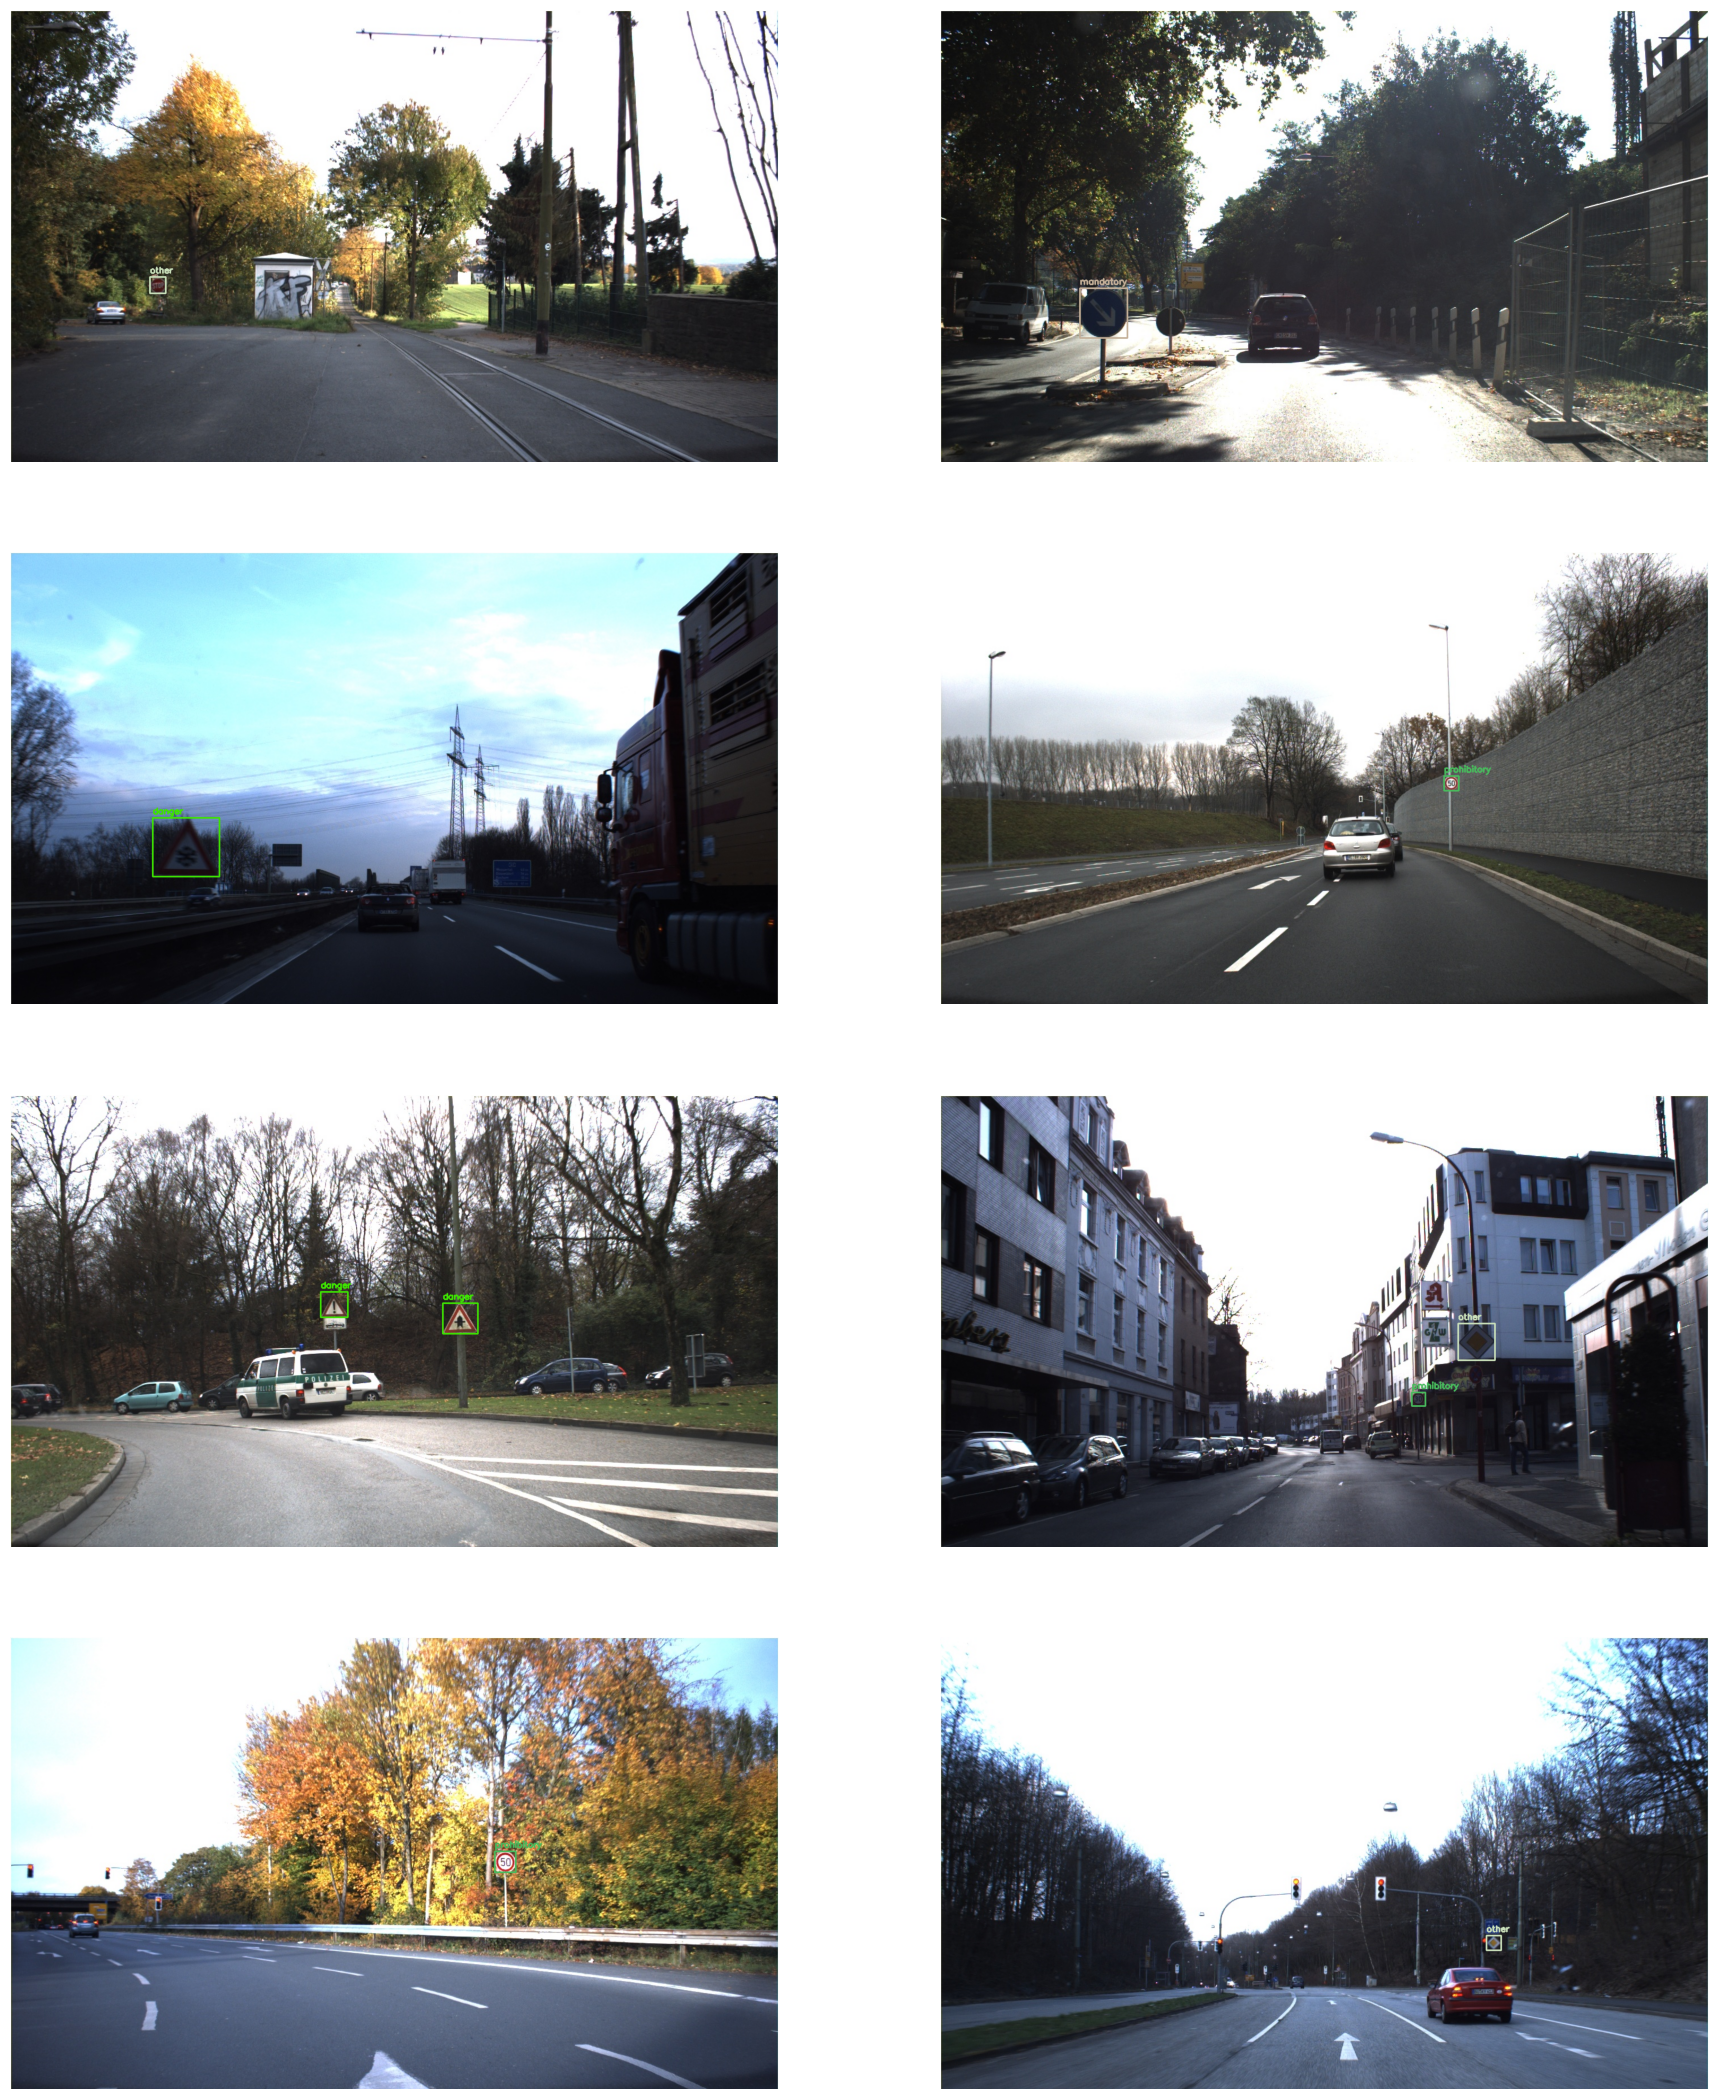

In [10]:
# Sample a set of random images
sampled_images = random.sample(image_files, 8)

# Generate random colors for each class
colors = generate_random_colors(len(class_names))

plot_images_with_bboxes(sampled_images, data_dir, class_names, colors)

# Number of instances for each class

In [11]:
class_instance_counts = {class_id: 0 for class_id in range(len(class_names))}

# Get list of label files
label_files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]

# Count the number of instances for each class
for label_file in label_files:
    label_path = os.path.join(data_dir, label_file)
    with open(label_path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            class_instance_counts[class_id] += 1

# Extract class names and counts for plotting
class_ids = list(class_instance_counts.keys())
instance_counts = pd.Series((class_instance_counts.values()),name="counts")
class_labels = pd.Series([class_names[class_id] for class_id in class_ids],name="class")

df = pd.concat([class_labels,instance_counts],axis=1)
# Plot the class instance counts
iplot(px.bar(data_frame = df,x ="class",y="counts",color_discrete_sequence=px.colors.sequential.algae\
             ,title="Number of instances of each class",template="plotly_dark"))

# Initializing wandb and YOLOv8m

In [12]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("wandb_key")
wandb.login(key=secret_value)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [13]:
model = YOLO("yolov8m.yaml")

# Training model

In [14]:
results = model.train(
    data='/kaggle/working/dataset.yaml',  # Path to your dataset configuration file
    epochs = 100
)

Ultralytics YOLOv8.2.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/kaggle/working/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 22.7MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

wandb: Currently logged in as: diaa_k (diaa_k-personal). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240728_080721-eb7otluf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train
wandb: ⭐️ View project at https://wandb.ai/diaa_k-personal/YOLOv8
wandb: 🚀 View run at https://wandb.ai/diaa_k-personal/YOLOv8/runs/eb7otluf


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 89.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/traffic-signs-dataset-in-yolo-format/ts/ts... 592 images, 0 backgrounds, 0 corrupt: 100%|██████████| 592/592 [00:02<00:00, 275.28it/s]

train: WARNING ⚠️ /kaggle/input/traffic-signs-dataset-in-yolo-format/ts/ts/00340.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/traffic-signs-dataset-in-yolo-format/ts is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

val: Scanning /kaggle/input/traffic-signs-dataset-in-yolo-format/ts/ts... 149 images, 0 backgrounds, 0 corrupt: 100%|██████████| 149/149 [00:00<00:00, 275.13it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/traffic-signs-dataset-in-yolo-format/ts is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.94G      6.208      39.13      3.984         57        640: 100%|██████████| 37/37 [00:23<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        149        247          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.56G      4.614      14.52      3.171         59        640: 100%|██████████| 37/37 [00:22<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

                   all        149        247          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.66G      3.353      6.677      2.131         35        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

                   all        149        247      0.506    0.00647    0.00343    0.00109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.55G      2.918      4.614      1.709         53        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        149        247      0.296     0.0949     0.0336     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.64G      2.518      3.693      1.422         40        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        149        247      0.572      0.166     0.0779     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.85G      2.372      3.331      1.317         42        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        149        247      0.378      0.151      0.151     0.0766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.65G      2.219      2.851      1.252         41        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        149        247       0.37      0.211      0.195      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.54G       1.99      2.517      1.173         39        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        149        247      0.378      0.307      0.357      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.66G      1.966      2.384      1.136         49        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        149        247      0.913      0.226      0.419      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.85G      1.842       2.18      1.117         45        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        149        247      0.519      0.437      0.495      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.64G      1.786      2.019      1.094         33        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        149        247      0.665      0.482      0.559      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.55G      1.707      1.803      1.056         35        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        149        247      0.813      0.503      0.595      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.65G      1.657      1.671      1.064         44        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        149        247      0.765      0.574      0.644      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.65G       1.52       1.52      1.015         31        640: 100%|██████████| 37/37 [00:22<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        149        247      0.839      0.564      0.677       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.64G       1.43      1.397     0.9907         51        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        149        247      0.715      0.618      0.708       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.54G       1.38      1.326     0.9852         40        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        149        247      0.849      0.634      0.729      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.65G      1.358      1.278     0.9851         39        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        149        247      0.911      0.632       0.73      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.64G      1.324      1.144     0.9803         43        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        149        247      0.904      0.648       0.76       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.85G      1.326      1.155     0.9678         36        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        149        247      0.902      0.668      0.775      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.54G      1.173      1.016     0.9399         45        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        149        247      0.919      0.691        0.8      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.65G      1.202      1.047     0.9279         47        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        149        247       0.89      0.729       0.82      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.64G       1.18      1.012     0.9441         59        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

                   all        149        247       0.93      0.764       0.82      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.64G      1.136     0.9258     0.9159         47        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        149        247      0.939      0.736      0.838      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.54G      1.122     0.9277      0.921         41        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        149        247      0.912      0.775      0.829      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.65G      1.067      0.854     0.9139         41        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        149        247      0.967      0.775      0.858      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.64G      1.133      0.884     0.9194         47        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        149        247      0.911      0.756      0.843        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.64G      1.088     0.8171      0.899         44        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        149        247      0.945      0.762      0.854      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.54G       1.06     0.8137     0.9141         45        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        149        247       0.92       0.77       0.85      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.65G       1.07     0.8278     0.9068         43        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        149        247      0.935      0.797      0.876      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.64G      1.046     0.8226     0.9036         60        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        149        247      0.862      0.784      0.854      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.65G      1.023     0.7971     0.8895         49        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        149        247       0.95      0.797      0.885      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.54G     0.9643     0.7438     0.8806         41        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        149        247      0.972      0.802      0.889      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.65G     0.9929     0.7435     0.8869         44        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        149        247      0.906      0.817      0.875      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.64G     0.9512     0.7381     0.8739         65        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        149        247      0.938      0.789       0.87      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.84G     0.9804     0.7099     0.8884         50        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

                   all        149        247      0.921      0.809      0.893      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.54G     0.9577     0.7017     0.8794         57        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        149        247      0.951      0.812      0.887       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.65G     0.9395      0.662     0.8784         52        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        149        247      0.939      0.828      0.893      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.64G     0.9581     0.6698     0.8725         35        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

                   all        149        247      0.931       0.82      0.884      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.64G     0.9894     0.6743     0.8804         43        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        149        247      0.944      0.815      0.888      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.54G     0.9311     0.6705     0.8675         35        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        149        247      0.935      0.821      0.901      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.65G     0.8785      0.651     0.8633         36        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        149        247      0.955      0.818      0.886      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.64G     0.8782     0.6523     0.8691         48        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        149        247      0.973      0.804      0.902      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.85G     0.8895      0.621     0.8588         45        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

                   all        149        247      0.975       0.83      0.895      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.54G     0.9069     0.6242      0.865         51        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        149        247      0.945      0.852      0.915       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.65G     0.8734     0.6038     0.8688         54        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        149        247       0.97      0.823        0.9      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.64G      0.882     0.5981     0.8655         42        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        149        247       0.98      0.846      0.909      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.64G     0.8739     0.5985     0.8624         34        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        149        247      0.919       0.86      0.903      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.54G     0.8586     0.5834     0.8555         42        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        149        247      0.955      0.842      0.923      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.65G     0.8444     0.5774     0.8466         40        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        149        247      0.985      0.809      0.916      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.64G     0.8519     0.5812     0.8502         34        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        149        247      0.965      0.857      0.923      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.65G     0.8236     0.5563      0.843         43        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        149        247      0.977      0.825      0.914      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.54G     0.8252     0.5572     0.8459         42        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        149        247      0.981      0.839      0.915      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.65G     0.8538     0.5746     0.8582         33        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        149        247      0.962      0.857      0.917      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.64G     0.8511     0.5512     0.8433         54        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        149        247      0.953      0.853      0.924      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.64G     0.8139     0.5471     0.8482         60        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

                   all        149        247      0.922      0.887      0.925      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.55G     0.7856     0.5271     0.8367         41        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        149        247      0.949      0.883      0.939      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.66G     0.7837     0.5127     0.8457         53        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        149        247      0.963      0.889      0.941      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.85G     0.7891     0.5212     0.8462         48        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        149        247      0.978      0.853      0.939      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.64G     0.8128     0.5288     0.8395         52        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        149        247      0.929       0.88      0.927      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.54G     0.7952     0.5312       0.84         26        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        149        247      0.965      0.854      0.933      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.66G     0.8037      0.523     0.8467         46        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        149        247      0.983      0.852       0.93      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.64G     0.7653     0.5176     0.8316         45        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        149        247       0.94      0.891      0.935      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.64G     0.7823     0.5174     0.8315         47        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        149        247      0.959      0.888      0.933      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.54G     0.7561     0.4994     0.8338         33        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        149        247      0.977      0.867      0.941      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.65G     0.8076     0.5108     0.8372         46        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        149        247      0.965      0.877      0.944      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.63G     0.7882     0.5225     0.8449         33        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

                   all        149        247      0.947      0.886      0.933       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.63G     0.7272      0.482     0.8364         54        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        149        247      0.968      0.887      0.944      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.54G     0.7524     0.4889     0.8357         45        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        149        247      0.971      0.875       0.94      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.64G     0.7641     0.4895     0.8505         31        640: 100%|██████████| 37/37 [00:22<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        149        247      0.959      0.876      0.947       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.65G     0.7376     0.4879     0.8318         44        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        149        247      0.978      0.872       0.94      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.65G     0.7095     0.4607     0.8244         54        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        149        247      0.971      0.858      0.938      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.54G      0.745     0.4767     0.8376         42        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        149        247      0.983      0.849      0.937      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.65G     0.7034     0.4637      0.832         41        640: 100%|██████████| 37/37 [00:22<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        149        247      0.957      0.889      0.943      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.65G     0.7092     0.4682     0.8351         32        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

                   all        149        247      0.964      0.881      0.939      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.65G     0.7075     0.4611      0.829         50        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        149        247      0.967      0.863      0.946      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.54G     0.6958     0.4472     0.8318         52        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        149        247      0.969      0.861      0.943      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.64G     0.7148     0.4499      0.831         39        640: 100%|██████████| 37/37 [00:22<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

                   all        149        247      0.947      0.897      0.945      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.85G     0.7019      0.448     0.8271         60        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        149        247      0.954      0.883      0.948      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.64G     0.6989     0.4346     0.8309         36        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        149        247      0.959       0.88      0.947      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.54G     0.6817     0.4331      0.822         37        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        149        247      0.978      0.873      0.943      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.65G     0.7208     0.4473     0.8286         52        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        149        247      0.926      0.915       0.95      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.85G     0.6908     0.4322     0.8223         50        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        149        247      0.978      0.878      0.951      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.85G     0.7036     0.4477     0.8208         41        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        149        247      0.992      0.883      0.954      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.54G     0.6768     0.4219     0.8187         53        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        149        247      0.979      0.923      0.959      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.65G     0.6548     0.4172     0.8148         47        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

                   all        149        247      0.978      0.908      0.954      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.64G     0.6558     0.4142     0.8134         63        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        149        247      0.982      0.912      0.956      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.64G     0.6568     0.4111     0.8226         37        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        149        247      0.971      0.912      0.957       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.54G     0.6607     0.4091     0.8252         57        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        149        247      0.969      0.911      0.957      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.86G     0.6642     0.4159     0.8195         47        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        149        247      0.955      0.929      0.956      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.64G     0.6745     0.4192     0.8206         47        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        149        247      0.981      0.912      0.959      0.756


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.64G     0.6714     0.4282     0.8213         22        640: 100%|██████████| 37/37 [00:23<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        149        247      0.985      0.902      0.952      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.54G     0.6243     0.3838     0.8095         29        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        149        247      0.967      0.905      0.951      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.65G     0.6227     0.3977     0.8115         27        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        149        247       0.96      0.905      0.951      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.64G     0.6238     0.3817     0.8238         25        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        149        247       0.98      0.894      0.951      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.85G     0.6033     0.3839     0.8226         29        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        149        247      0.989      0.894      0.954      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.54G     0.6111     0.3874     0.8208         25        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        149        247      0.986        0.9      0.955      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.65G      0.598     0.3762     0.8183         24        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        149        247      0.979      0.897      0.954      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.64G      0.583     0.3678     0.8168         26        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        149        247      0.983      0.899      0.955      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.85G     0.5858     0.3662     0.8157         23        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        149        247      0.993      0.899      0.956       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.55G     0.6061     0.3728     0.8094         28        640: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        149        247      0.991      0.901      0.956      0.793



100 epochs completed in 0.719 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8m summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


                   all        149        247       0.99      0.894      0.954      0.796
           prohibitory         77        116          1       0.94      0.989      0.835
                danger         32         39          1      0.988      0.995      0.877
             mandatory         28         35      0.975      0.857      0.924      0.744
                 other         46         57      0.985      0.789      0.909      0.728
Speed: 0.1ms preprocess, 6.8ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/detect/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇▇███████████████████████
wandb:     metrics/mAP50-95(B) ▁▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇███████
wandb:    metrics/precision(B) ▁▅▄▄▆▆▇▇▇█▇█████████████████████████████
wandb:       metrics/recall(B) ▁▁▂▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███▇███████████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/cls_loss █▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:            val/box_loss █▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁

# Evaluating model

In [15]:
metrics = model.val(data ='/kaggle/working/dataset.yaml')

Ultralytics YOLOv8.2.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8m summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /kaggle/input/traffic-signs-dataset-in-yolo-format/ts/ts... 149 images, 0 backgrounds, 0 corrupt: 100%|██████████| 149/149 [00:00<00:00, 771.92it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/traffic-signs-dataset-in-yolo-format/ts is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


                   all        149        247       0.99      0.894      0.954      0.798
           prohibitory         77        116      0.999       0.94      0.989       0.84
                danger         32         39          1      0.988      0.995      0.871
             mandatory         28         35      0.974      0.857      0.924      0.753
                 other         46         57      0.985      0.789      0.909      0.729
Speed: 0.4ms preprocess, 12.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train2


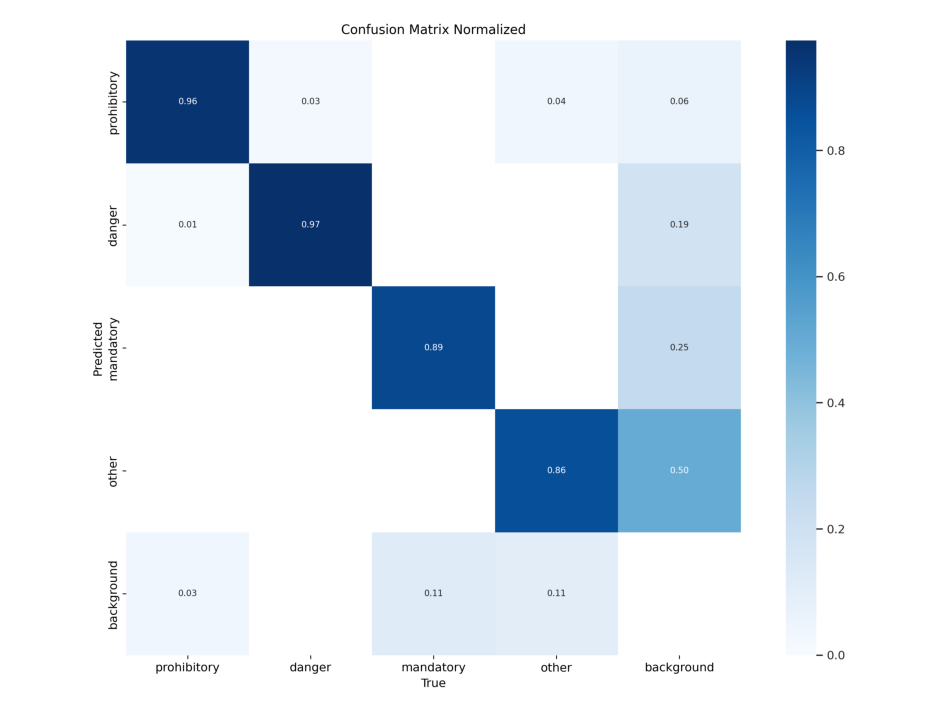

In [16]:
img = plt.imread('/kaggle/working/runs/detect/train/confusion_matrix_normalized.png')
plt.figure(figsize=(12,9))
plt.imshow(img)
plt.axis('off')
plt.show()

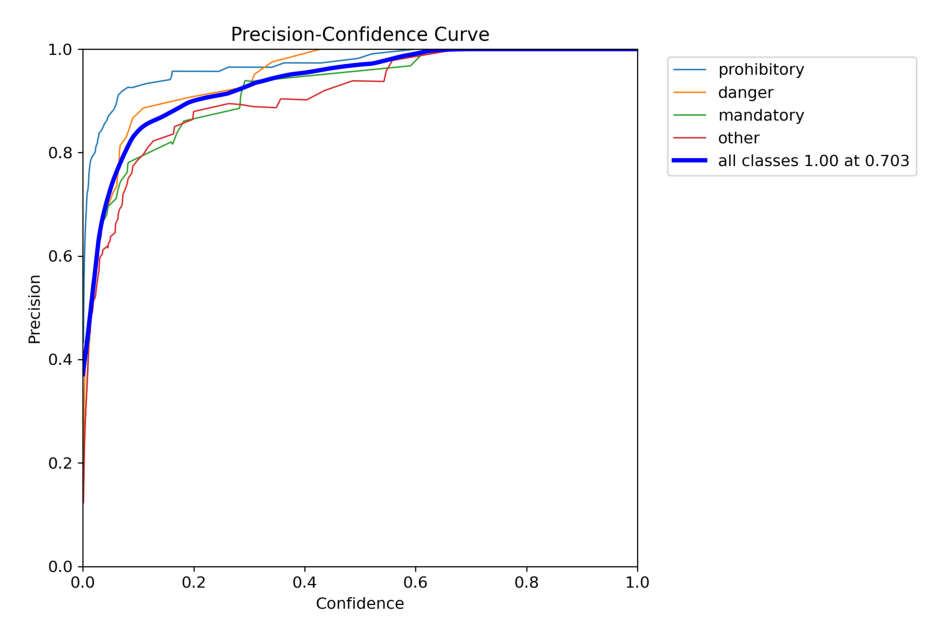

In [17]:
img = plt.imread('/kaggle/working/runs/detect/train/P_curve.png')
plt.figure(figsize=(12,9))
plt.imshow(img)
plt.axis('off')
plt.show()

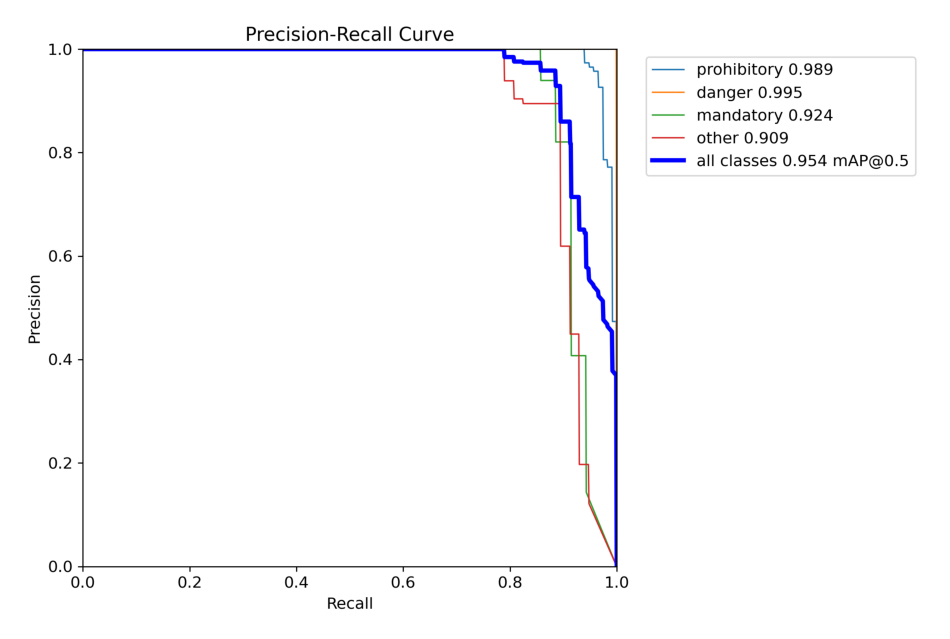

In [18]:
img = plt.imread('/kaggle/working/runs/detect/train/PR_curve.png')
plt.figure(figsize=(12,9))
plt.imshow(img)
plt.axis('off')
plt.show()

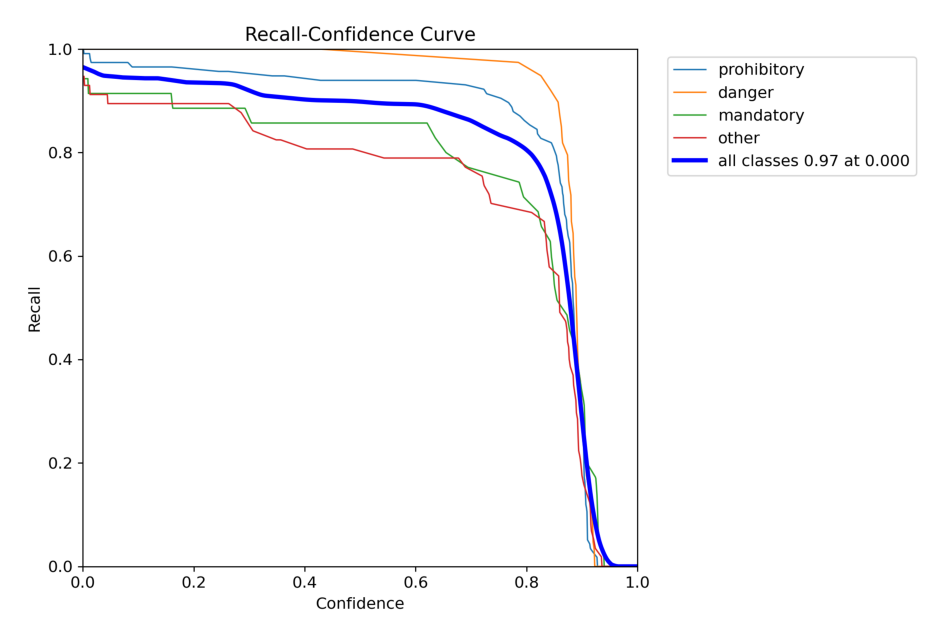

In [19]:
img = plt.imread('/kaggle/working/runs/detect/train/R_curve.png')
plt.figure(figsize=(12,9))
plt.imshow(img)
plt.axis('off')
plt.show()

# Predicting image and video using model

In [20]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt \
source='/kaggle/input/traffic-signs-dataset-in-yolo-format/ts/ts/00028.jpg'

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Ultralytics YOLOv8.2.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8m summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 /kaggle/input/traffic-signs-dataset-in-yolo-format/ts/ts/00028.jpg: 384x640 1 danger, 1 mandatory, 87.6ms
Speed: 4.3ms preprocess, 87.6ms inference, 144.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


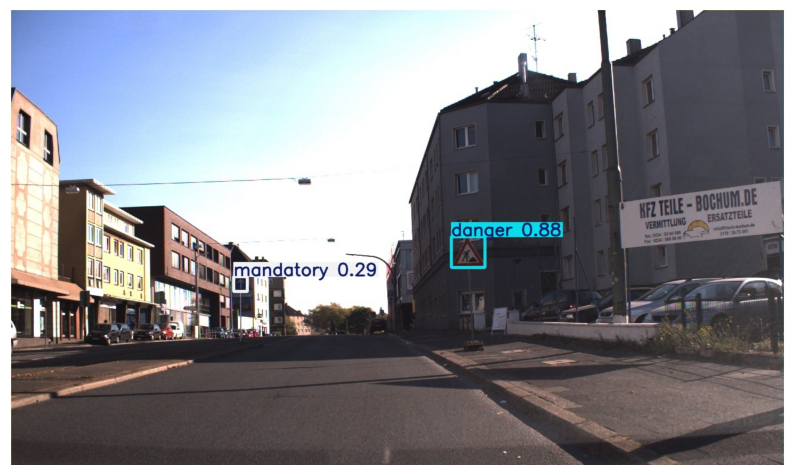

In [21]:
img_path = '/kaggle/working/runs/detect/predict/00028.jpg'
img = plt.imread(img_path)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis(False)
plt.show()

In [22]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt source= r"G:\Yolo traffic signs\Traffic-signs-detection-using-YOLO-and-streamlit-\traffic-sign-to-test.mp4"

Ultralytics YOLOv8.2.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8m summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs

video 1/1 (frame 1/56) /kaggle/input/traffic-signs-dataset-in-yolo-format/traffic-sign-to-test.mp4: 384x640 2 prohibitorys, 72.7ms
video 1/1 (frame 2/56) /kaggle/input/traffic-signs-dataset-in-yolo-format/traffic-sign-to-test.mp4: 384x640 2 prohibitorys, 12.3ms
video 1/1 (frame 3/56) /kaggle/input/traffic-signs-dataset-in-yolo-format/traffic-sign-to-test.mp4: 384x640 2 prohibitorys, 12.2ms
video 1/1 (frame 4/56) /kaggle/input/traffic-signs-dataset-in-yolo-format/traffic-sign-to-test.mp4: 384x640 2 prohibitorys, 12.3ms
video 1/1 (frame 5/56) /kaggle/input/traffic-signs-dataset-in-yolo-format/traffic-sign-to-test.mp4: 384x640 2 prohibitorys, 1 other, 12.2ms
video 1/1 (frame 6/56) /kaggle/input/traffic-signs-dataset-in-yolo-format/traffic-sign-to-test.mp4: 384x640 2 prohibitorys, 1 other, 12.2ms
video 1/1 (frame 

In [23]:
import io 
from IPython.display import HTML
from base64 import b64encode
def show_video(file_name, width=640):
  # show resulting deepsort video
  mp4 = open(file_name,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width="{0}" controls>
        <source src="{1}" type="video/mp4">
  </video>
  """.format(width, data_url))

In [24]:
# Convert avi to mp4
!ffmpeg -y -loglevel panic -i results/runs/detect/predict2/traffic-sign-to-test.avi output.mp4


In [25]:
# output object tracking video
path_output = "results/output.mp4"
show_video(path_output, width=960)

